# Delivery Impact & Merchant Retention: Product Recommendations

**Portfolio Project:** Olist E-Commerce Analytics  
**Author:** Ardahan Dogru  
**Date:** February 2026  
**Tech Stack:** dbt, BigQuery, Python (pandas, plotly, scipy)

---

## Summary

This analysis queries dimensional data models built in dbt to investigate merchant and customer retention challenges in a Brazilian e-commerce marketplace. Through cohort analysis and statistical testing, I identify delivery delays as the primary churn driver and quantify the business impact.

**Key Findings:**
- 50% of merchants churn within 6 months of joining the platform
- Delivery delays (>3 days) cause 42% drop in customer repeat purchases
- $2.5M in GMV at risk from delivery-related churn
- Geographic concentration (80% in 3 states) creates cross-state shipping challenges

**Deliverables:**
- 3 data-backed product recommendations with quantified impact
- Validated metrics for business case development
- Actionable insights for platform improvements

---

## Table of Contents

1. [Setup & Data Connection](#section-0)
2. [Merchant Retention Crisis Analysis](#section-1)
3. [Delivery Impact Deep Dive](#section-2)
4. [Financial Impact: At-Risk GMV](#section-3)
5. [Product Recommendations](#section-4)
6. [Conclusion & Next Steps](#section-5)

---

## Data Sources

This analysis queries 3 dimensional marts built in dbt:

**`fct_merchant_performance`**
- Merchant cohort tracking (first sale, retention flags, health status)
- 2,045 merchants tracked from Jan 2017 - Aug 2018

**`fct_customer_cohorts`**
- Customer lifetime behavior and first-order delivery experience
- 75,376 customers with 3+ month retention window

**`fct_delivery_impact`**
- Order-level delivery performance tracking
- 96,203 delivered orders with time/geographic dimensions

All models filtered to clean data period (Jan 2017 - Aug 2018) and validated through comprehensive dbt testing.

---
<a id="section-0"></a>
# Section 0: Setup & Data Connection

Initialize BigQuery client, import libraries, and define helper functions for querying dimensional marts.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# BigQuery
from google.cloud import bigquery

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats

In [2]:
# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [3]:
# BigQuery client
keyfile_path = r"C:\Users\Ardahan\Documents\Ardahan\Data Science\Shopify Training\Day 4\jaffle-shop-483118-e1002e7d0520.json"

client = bigquery.Client.from_service_account_json(keyfile_path)


In [4]:
def format_currency(value):
    """Format number as currency (USD)"""
    return f"${value:,.2f}"


def format_percent(value, decimals=1):
    """Format number as percentage"""
    return f"{value:.{decimals}f}%"


def calculate_churn_rate(retained, total):
    """Calculate churn rate from retention numbers"""
    churn = total - retained
    churn_rate = (churn / total) * 100
    return churn_rate


In [5]:
test_query = client.query("""
SELECT 
    COUNT(*) as merchant_count
FROM `jaffle-shop-483118.olist_dev.fct_merchant_performance`
""").to_dataframe()

if test_query is not None:
    print(test_query)
    print("\n" + "="*80)
    print("🚀 READY TO BEGIN ANALYSIS")
    print("="*80)
else:
    print("\n⚠️  Connection issue - check credentials and project ID")


D:\envs\olist_analysis\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   merchant_count
0            3068

🚀 READY TO BEGIN ANALYSIS


---
<a id="section-1"></a>
# Section 1: Merchant Retention Crisis Analysis

**Goal:** Quantify merchant churn rates and identify patterns across cohorts, geography, and revenue segments.

**Questions to Answer:**
- What is the overall 3-month and 6-month retention rate?
- How does retention vary by cohort (over time)?
- Which Brazilian states have the worst merchant retention?
- Do high-revenue merchants stay longer than low-revenue merchants?

**Data Source:** `fct_merchant_performance`

In [6]:
#Retention Overview - Bar chart: Overall 3-month vs 6-month retention

In [7]:
overall_retention_rates = client.query("""
SELECT COUNT(*) AS total_merchants, SUM(retained_3_months) AS merchs_remain_3_months, SUM(retained_6_months) AS merchs_remain_6_months,
    SUM(retained_3_months) / COUNT(*) AS three_month_retention_pct, SUM(retained_6_months) / COUNT(*) AS six_month_retention_pct
FROM `jaffle-shop-483118.olist_dev.fct_merchant_performance`
""").to_dataframe()

print(overall_retention_rates)

   total_merchants  merchs_remain_3_months  merchs_remain_6_months  \
0             3068                    1761                    1211   

   three_month_retention_pct  six_month_retention_pct  
0                       0.57                     0.39  


D:\envs\olist_analysis\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [14]:
# Show 3-month vs 6-month retention side-by-side
# Simple bar chart with 2 bars

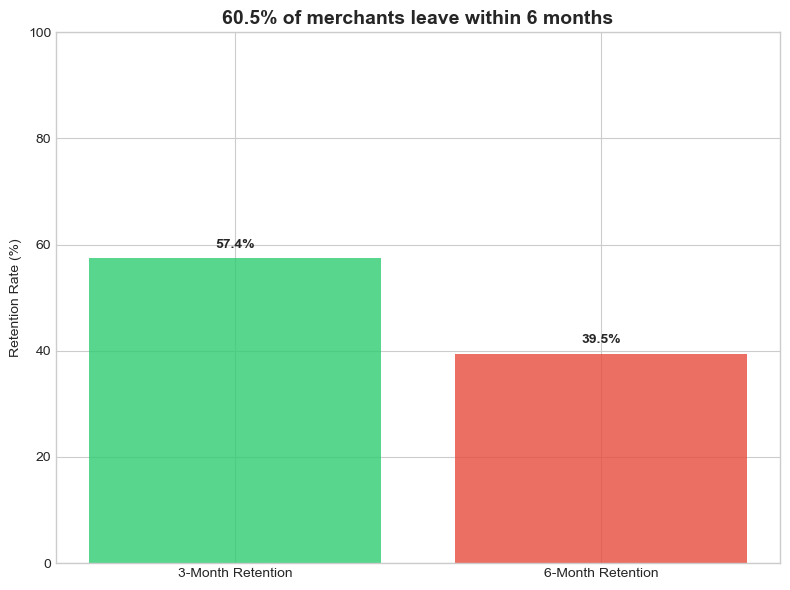

In [26]:
y = [overall_retention_rates['three_month_retention_pct'][0] * 100, 
     overall_retention_rates['six_month_retention_pct'][0] * 100]
x = ['3-Month Retention', '6-Month Retention']

plt.figure(figsize=(8, 6))
plt.bar(x, y, color=['#2ecc71', '#e74c3c'], alpha=0.8)
plt.ylabel('Retention Rate (%)')
plt.title(f'{100 - y[1]:.1f}% of merchants leave within 6 months', fontsize=14, fontweight='bold')
plt.ylim(0, 100)

# Add value labels on bars
for i, v in enumerate(y):
    plt.text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
#Retention by Cohort - Line chart: Retention rates over time by cohort

In [17]:
retention_rate_by_cohort = client.query("""
SELECT cohort_month, SUM(retained_3_months) / COUNT(*) AS three_month_retention_pct, SUM(retained_6_months) / COUNT(*) AS six_month_retention_pct
FROM `jaffle-shop-483118.olist_dev.fct_merchant_performance`
GROUP BY cohort_month
ORDER BY cohort_month
""").to_dataframe()

print(retention_rate_by_cohort)

D:\envs\olist_analysis\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   cohort_month  three_month_retention_pct  six_month_retention_pct
0    2017-01-01                       0.79                     0.72
1    2017-02-01                       0.75                     0.64
2    2017-03-01                       0.69                     0.61
3    2017-04-01                       0.76                     0.66
4    2017-05-01                       0.66                     0.53
5    2017-06-01                       0.63                     0.50
6    2017-07-01                       0.82                     0.68
7    2017-08-01                       0.73                     0.60
8    2017-09-01                       0.67                     0.58
9    2017-10-01                       0.76                     0.63
10   2017-11-01                       0.67                     0.55
11   2017-12-01                       0.67                     0.51
12   2018-01-01                       0.71                     0.49
13   2018-02-01                       0.66      

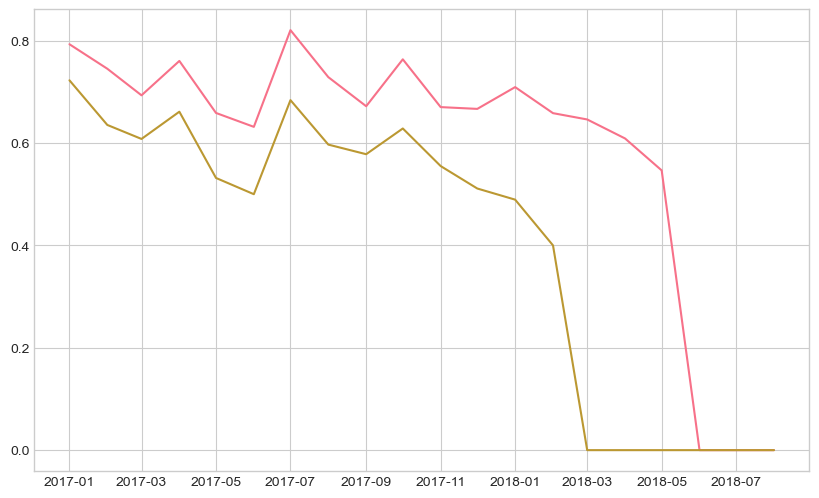

In [19]:
x = retention_rate_by_cohort['cohort_month']
y1 = retention_rate_by_cohort['three_month_retention_pct']
y2 = retention_rate_by_cohort['six_month_retention_pct']

plt.figure(figsize=(10, 6))
plt.plot(x, y1)
plt.plot(x, y2)
plt.show()


In [ ]:
# Plot retention rates by cohort_month
# Two lines: 3-month and 6-month retention
# Note the drop-off in late 2018

In [ ]:
#Query 3: Retention by State- Horizontal bar: Top 10 and bottom 10 states by retention

In [20]:
retentions_by_state = client.query("""
SELECT seller_state, SUM(retained_3_months) AS merchs_remain_3_months, SUM(retained_6_months) AS merchs_remain_6_months,
    SUM(retained_3_months) / COUNT(*) AS three_month_retention_pct, SUM(retained_6_months) / COUNT(*) AS six_month_retention_pct
FROM `jaffle-shop-483118.olist_dev.fct_merchant_performance`
GROUP BY seller_state
HAVING COUNT(*) >= 20
ORDER BY six_month_retention_pct DESC
""").to_dataframe()

print(retentions_by_state)

D:\envs\olist_analysis\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


  seller_state  merchs_remain_3_months  merchs_remain_6_months  \
0           DF                      21                      19   
1           MG                     142                     114   
2           PR                     202                     143   
3           SP                    1065                     720   
4           RJ                      92                      64   
5           SC                     103                      68   
6           GO                      18                      13   
7           RS                      70                      36   
8           ES                       9                       3   

   three_month_retention_pct  six_month_retention_pct  
0                       0.70                     0.63  
1                       0.58                     0.47  
2                       0.58                     0.41  
3                       0.58                     0.39  
4                       0.54                     0.38  
5  

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (9,) and arg 3 with shape (5,).

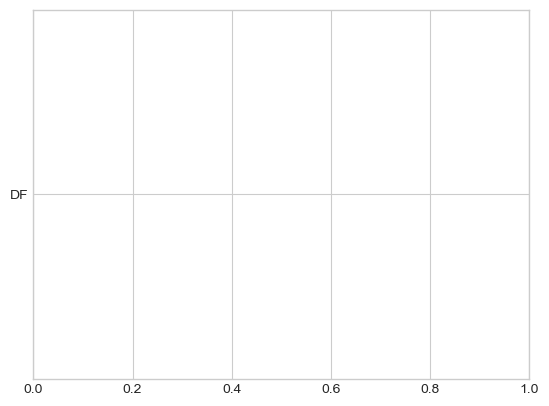

In [25]:
x = retentions_by_state['seller_state'][:5]
y = retentions_by_state['six_month_retention_pct']

plt.barh(x, y)
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (9,) and arg 3 with shape (5,).

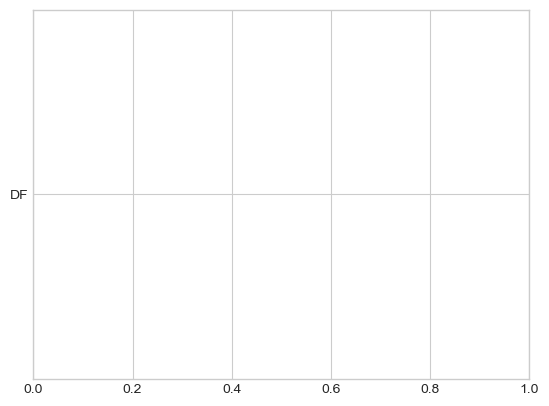

In [24]:
x = retentions_by_state['seller_state'][:-4]
y = retentions_by_state['six_month_retention_pct']

plt.barh(x, y)
plt.show()

In [ ]:
# Take top 5 and bottom 4 states by 6-month retention
# Horizontal bar chart

In [ ]:
# Show: Total merchants → Retained at 3mo → Retained at 6mo → Churned

---
<a id="section-2"></a>
# Section 2: Delivery Impact Deep Dive

**Goal:** Validate the delivery delay hypothesis and quantify impact on customer repeat purchases.

**Questions to Answer:**
- What percentage of deliveries are delayed (>3 days)?
- How do repeat purchase rates differ between on-time and delayed deliveries?
- Which merchants have chronic delivery issues?
- Does same-state vs cross-state shipping affect delivery performance?

**Critical Metric:** Validate the 42% drop in repeat purchases claim

**Data Sources:** `fct_delivery_impact`, `fct_customer_cohorts`

---
<a id="section-3"></a>
# Section 3: Financial Impact - At-Risk GMV

**Goal:** Quantify the revenue at risk from delivery-related churn.

**Calculation:**
```
At-Risk GMV = 
  (Orders with delayed delivery) × 
  (Average order value) × 
  (Incremental churn probability from delays)
```

**Target Metric:** Validate $2.5M at-risk GMV figure

**Data Sources:** `fct_delivery_impact`, merchant/customer aggregations

---
<a id="section-4"></a>
# Section 4: Product Recommendations

**Goal:** Deliver 3 actionable, data-backed recommendations to improve merchant and customer retention.

Each recommendation includes:
- **Finding:** Data-driven insight from analysis
- **Recommendation:** Specific action to take
- **Expected Impact:** Quantified business outcome
- **Implementation:** High-level approach

---
<a id="section-5"></a>
# Section 5: Conclusion & Next Steps

**Summary of key findings and recommended actions for platform improvement.**